In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
BATCH_SIZE = 128
N_NOISE = 100

GENERATOR_FILTERS = 64
CRITIC_FILTERS = 64
N_CHANNELS = 3

LAMBDA = 10
lr = 0.0001
beta1 = 0
beta2 = .9

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)

Files already downloaded and verified


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels=N_NOISE,
                           out_channels=GENERATOR_FILTERS*8,
                           kernel_size=4,
                           stride=1,
                           bias=False),
      nn.BatchNorm2d(GENERATOR_FILTERS*8),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=GENERATOR_FILTERS*8,
                         out_channels=GENERATOR_FILTERS*4,
                         kernel_size=4,
                         stride=2,
                         padding=1,
                         bias=False),
      nn.BatchNorm2d(GENERATOR_FILTERS*4),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=GENERATOR_FILTERS*4,
                         out_channels=GENERATOR_FILTERS*2,
                         kernel_size=4,
                         stride=2,
                         padding=1,
                         bias=False),
      nn.BatchNorm2d(GENERATOR_FILTERS*2),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=GENERATOR_FILTERS*2,
                         out_channels=GENERATOR_FILTERS,
                         kernel_size=4,
                         stride=2,
                         padding=1,
                         bias=False),
      nn.BatchNorm2d(GENERATOR_FILTERS),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=GENERATOR_FILTERS,
                         out_channels=N_CHANNELS,
                         kernel_size=1,
                         stride=1,
                         bias=False),
      nn.BatchNorm2d(N_CHANNELS),
      nn.Tanh(),
    )

  def forward(self, noise):
    return self.layers(noise)

In [ ]:
class Critic(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=N_CHANNELS, 
                  out_channels=CRITIC_FILTERS,
                  kernel_size=4,
                  stride=2, 
                  padding=1, 
                  bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=CRITIC_FILTERS, 
                  out_channels=CRITIC_FILTERS * 2, 
                  kernel_size=4, 
                  stride=2, 
                  padding=1, 
                  bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=CRITIC_FILTERS * 2, 
                  out_channels=CRITIC_FILTERS * 4, 
                  kernel_size=4, 
                  stride=2, 
                  padding=1,
                  bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=CRITIC_FILTERS * 4, 
                  out_channels=CRITIC_FILTERS * 8, 
                  kernel_size=4, 
                  stride=2, 
                  padding=1,
                  bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=CRITIC_FILTERS * 8, 
          out_channels=1, 
          kernel_size=4, 
          stride=2, 
          padding=1, 
          bias=False),

    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
generator = Generator().to(device)
critic = Critic().to(device)

In [ ]:
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
critic_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
def gradient_penalty(real_images, fake_images):
  eps = torch.rand(real_images.shape[0], 1, 1, 1).to(device)
  eps = eps.expand_as(real_images)

  interpolation = eps * real_images + (1 - eps) * fake_images
  scores = critic(interpolation)

  grad_outputs = torch.ones_like(scores)

  gradients = autograd.grad(
      outputs=scores,
      inputs=interpolation,
      grad_outputs=grad_outputs,
      create_graph=True,
      retain_graph=True
  )[0]

  gradients = gradients.view(BATCH_SIZE, -1)
  gradient_norm = gradients.norm(2, 1)
  penalty = torch.mean((gradient_norm - 1) ** 2)

  return penalty

def critic_loss(real_scores, fake_scores):
  real_scores = real_scores.mean()
  fake_scores = fake_scores.mean()

  error = fake_scores - real_scores
  return error

def generator_loss(generated_score):
  return -generated_score.mean()

In [ ]:
def plot_generated_images(noise):
  with torch.no_grad():
    n_images = noise.shape[0]
    generated_images = generator(noise).detach().cpu().numpy()

    fig, axs = plt.subplots(1, n_images, figsize=(10, 5))
    for i in range(n_images):
      img = (generated_images[i] + 1) / 2
      img = np.transpose(img, (1, 2, 0))
      axs[i].imshow(img)

    plt.show()

critic loss: -0.12140187621116638
generator loss: 0.09972752630710602



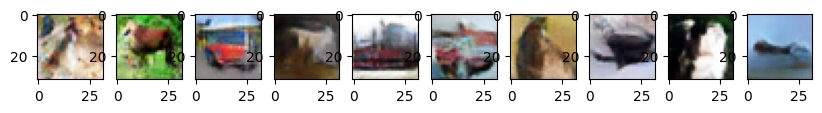

critic loss: 0.05064920336008072
generator loss: 0.28369206190109253



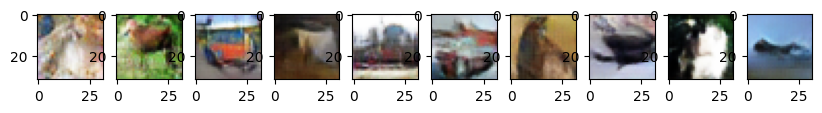

critic loss: -0.26442092657089233
generator loss: -0.3250342607498169



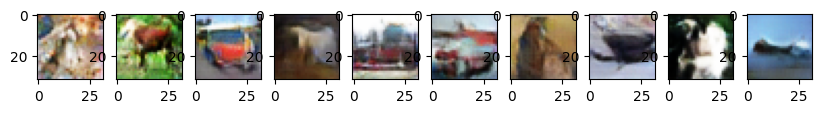

critic loss: -0.025983117520809174
generator loss: -0.22098353505134583



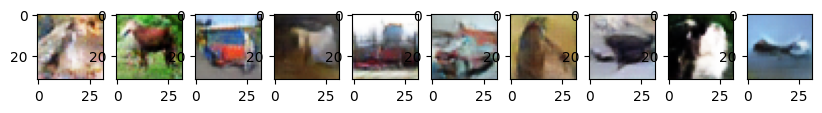

critic loss: -0.16182741522789001
generator loss: -0.11331972479820251



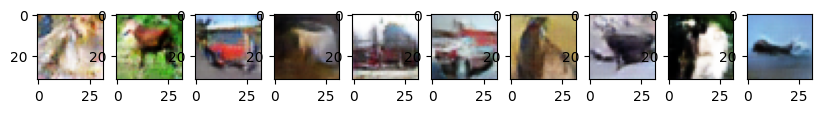

critic loss: -0.17446671426296234
generator loss: 0.5052555799484253



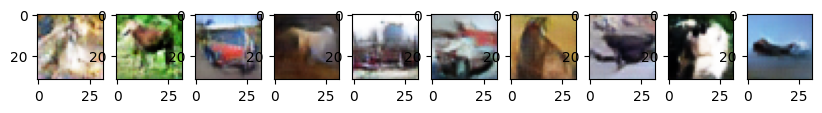

critic loss: -0.1548764407634735
generator loss: 0.45398300886154175



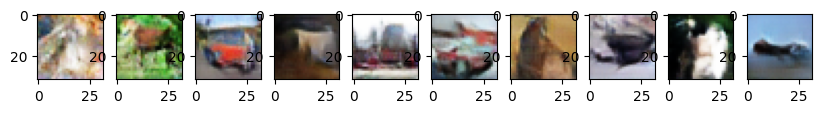

critic loss: -0.1885397881269455
generator loss: -0.1935054212808609



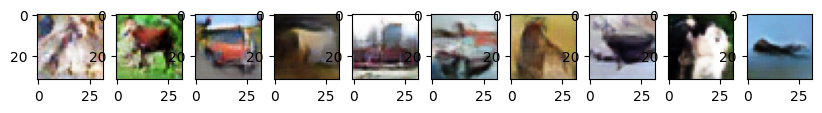

critic loss: -0.1981721818447113
generator loss: 0.7016716003417969



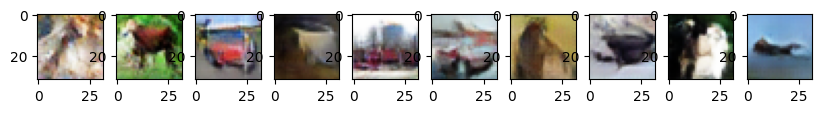

critic loss: -0.006908535957336426
generator loss: -0.020611532032489777



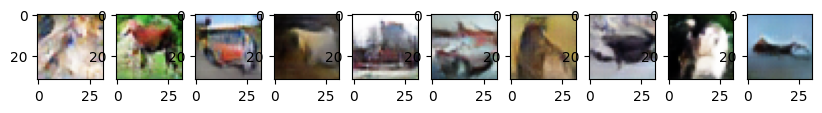

critic loss: -0.19701039791107178
generator loss: 0.6391226053237915



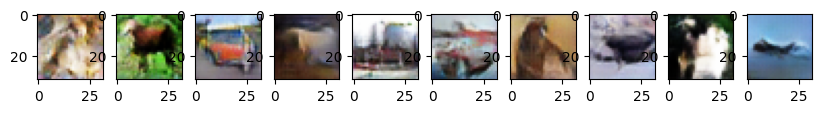

critic loss: -0.01916525699198246
generator loss: -0.48094528913497925



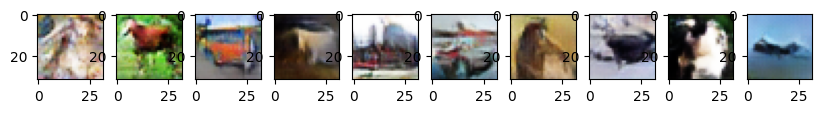

critic loss: -0.1378452181816101
generator loss: 0.186398446559906



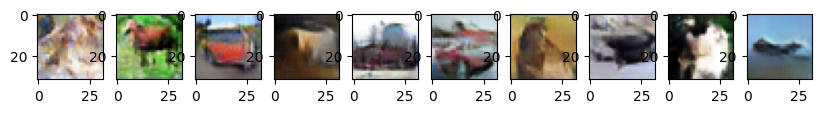

critic loss: 0.024287037551403046
generator loss: -0.2370317280292511



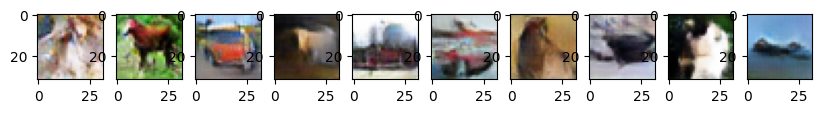

In [ ]:
epochs = 2

log_critic_loss = []
log_generator_loss = []

plot_noise = torch.randn((10, N_NOISE, 1, 1), device=device)

for epoch in range(1, epochs+1):
  for i, data in enumerate(trainloader):
    images, _ = data
    images = images.to(device)
    
    # updating the critic
    critic.zero_grad()

    ## calculating the score for real images
    real_scores = critic(images).view(-1)

    ## calculating the score for fake images
    noise = torch.randn((images.shape[0], N_NOISE, 1, 1), device=device)
    generated_images = generator(noise)

    fake_scores = critic(generated_images.detach()).view(-1)

    loss = critic_loss(real_scores, fake_scores) + LAMBDA * gradient_penalty(images, generated_images)
    loss.backward()
    critic_optimizer.step()

    log_critic_loss.append(loss.detach().cpu().item())
    
    #updating the generator
    generator.zero_grad()

    noise = torch.randn((BATCH_SIZE, N_NOISE, 1, 1), device=device)
    generated_images = generator(noise)
    scores = critic(generated_images).view(-1)

    loss = generator_loss(scores)
    loss.backward()
    generator_optimizer.step()

    log_generator_loss.append(loss.detach().cpu().item())

    if (i + 1) % 50 == 0:
      print(f'critic loss: {log_critic_loss[-1]}')
      print(f'generator loss: {log_generator_loss[-1]}')
      print()
      plot_generated_images(plot_noise)

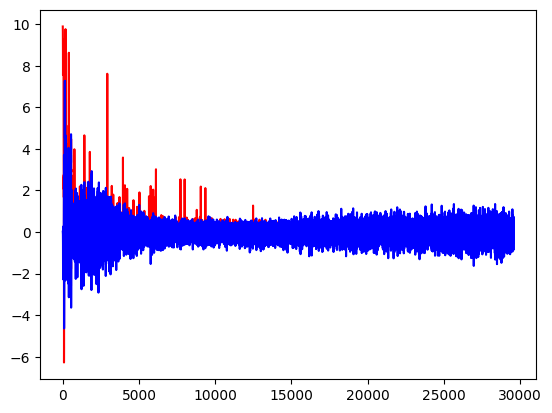

In [ ]:
plt.plot(log_critic_loss, color='red')
plt.plot(log_generator_loss, color='blue')

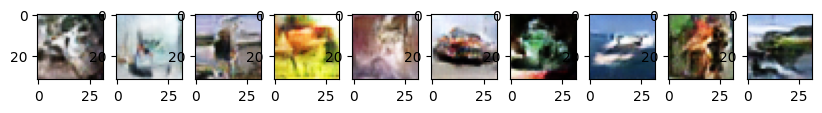

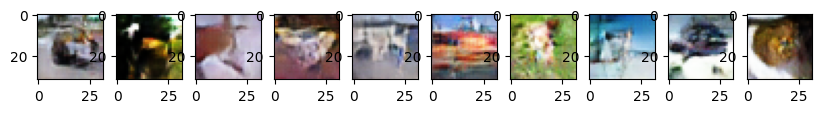

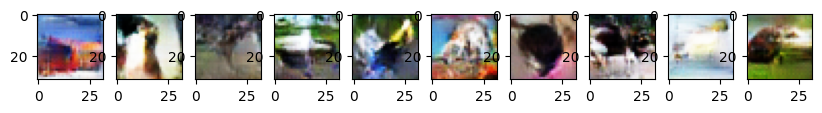

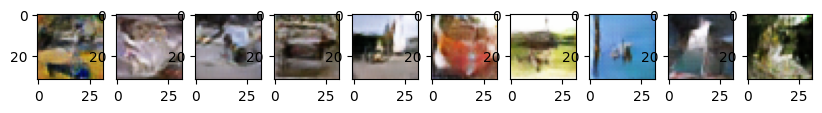

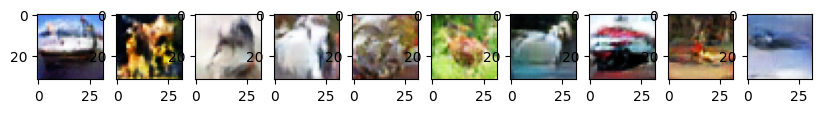

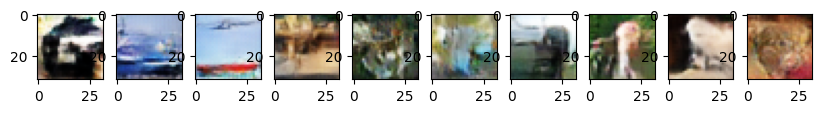

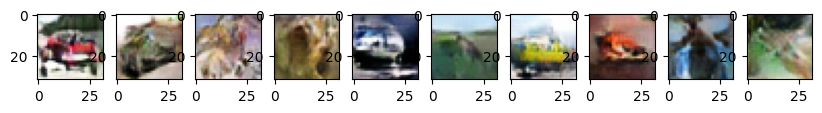

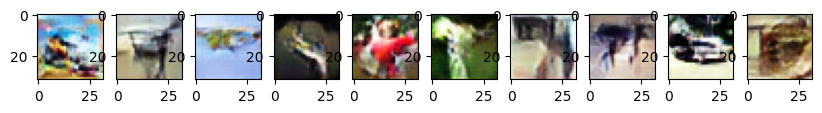

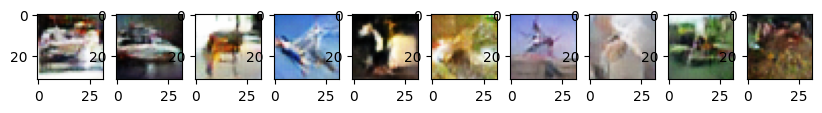

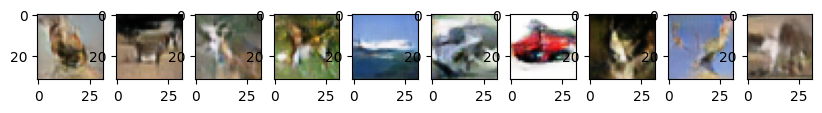

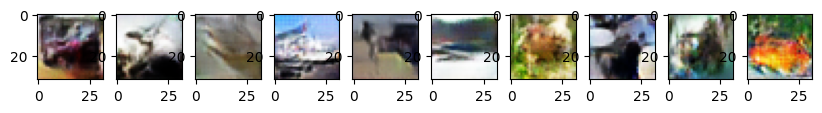

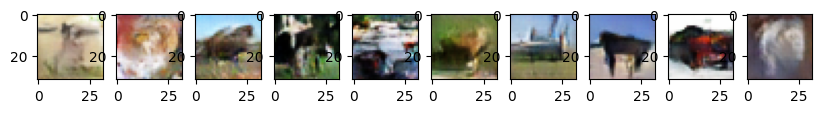

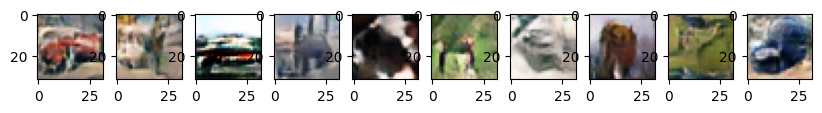

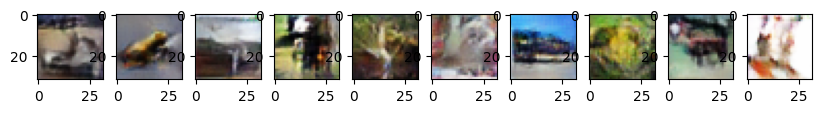

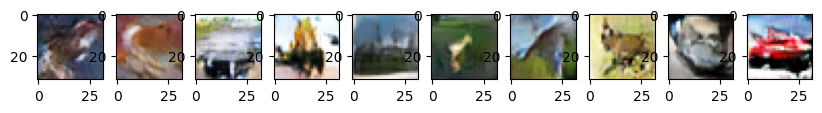

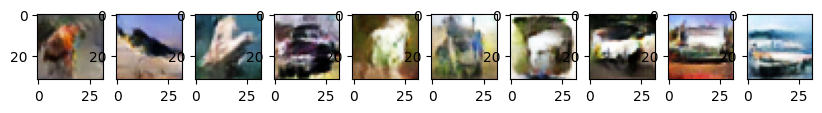

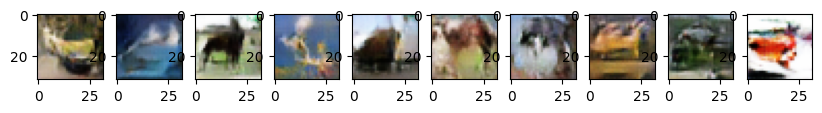

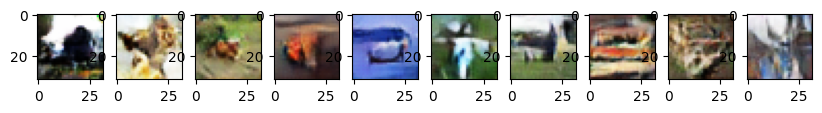

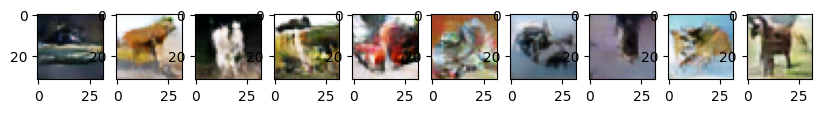

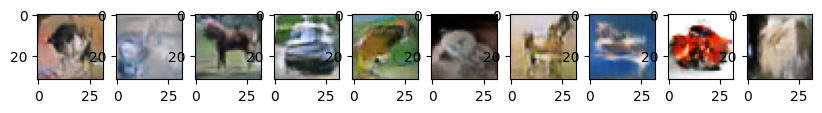

In [ ]:
for i in range(20):
  plot_noise = torch.randn((10, N_NOISE, 1, 1), device=device)
  plot_generated_images(plot_noise)